# Assement 3

Prepared by: Ray Mcgregor

In [1]:
# Import Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
from scipy import stats



# Import Dataset

In [3]:

column_names = [
"Sex","Length","Diameter","Height","Whole_weight","Shucked_weight","Viscera_weight","Shell_weight","Rings"]
raw_data = pd.read_csv('abalone.data', header=None, names=column_names)
# Dataset source: http://archive.ics.uci.edu/ml/datasets/Abalone
raw_data


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## Format Data

In [4]:
data_df = raw_data.copy()
data_df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## Convert Rings to be a Categorical Variable

In [5]:
#data_df['Ring Age'] = data_df['Rings'].astype('category')
invalid_rings = []

for i in range(len(data_df)):
    if data_df.loc[i, 'Rings'] <= 7:
        category = 1
    elif data_df.loc[i, 'Rings'] <= 10:
        category = 2
    elif data_df.loc[i, 'Rings'] <= 15:
        category = 3
    elif data_df.loc[i, 'Rings'] > 15:
        category = 4
    else:
        invalid_rings.append(data_df.loc[i, 'Rings'])

    data_df.loc[i, 'Ring Age'] = category

# print counts for each ring age in ascending order based on the ring age index
print(data_df['Ring Age'].value_counts().sort_index())
print()
print(data_df['Ring Age'].describe())
print(f"Invalid Examples Detected: ", invalid_rings)




1.0     839
2.0    1891
3.0    1186
4.0     261
Name: Ring Age, dtype: int64

count    4177.000000
mean        2.208044
std         0.831638
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: Ring Age, dtype: float64
Invalid Examples Detected:  []


## Data Preprocessing

In [6]:
# Null Values
nulls = data_df.isnull().sum()
print("Missing values:\n", nulls)

Missing values:
 Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
Ring Age          0
dtype: int64


In [7]:
# exclude non-numeric columns
numeric_data = data_df.select_dtypes(include=[np.number])

Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Detect outliers
outliers = ((numeric_data < (Q1 - 1.5 * IQR)) | (numeric_data > (Q3 + 1.5 * IQR))).any(axis=1)
print("Number of rows with outliers:", outliers.sum())
outliers.describe()

Number of rows with outliers: 396


count      4177
unique        2
top       False
freq       3781
dtype: object

In [8]:
# Select only numerical columns
numerical_df = data_df.select_dtypes(include=['number'])

# Initialize a dictionary to hold outlier details
outliers_info = {}

# Calculate IQR and detect outliers for each column
for column in numerical_df.columns:
    Q1 = numerical_df[column].quantile(0.25)
    Q3 = numerical_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)]

    # Store information about outliers
    outliers_info[column] = {
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Number of Outliers': outliers.shape[0],
        'Outliers Details': outliers
    }

# Print the outlier information for each column
for column, info in outliers_info.items():
    print(f"Column: {column}")
    print(f"  IQR: {info['IQR']}")
    print(f"  Lower Bound: {info['Lower Bound']}")
    print(f"  Upper Bound: {info['Upper Bound']}")
    print(f"  Number of Outliers: {info['Number of Outliers']}")
    print(f"  Outliers Details:\n{info['Outliers Details']}\n\n")


Column: Length
  IQR: 0.16499999999999998
  Lower Bound: 0.20250000000000004
  Upper Bound: 0.8624999999999999
  Number of Outliers: 49
  Outliers Details:
      Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
148    0.175     0.130   0.055        0.0315          0.0105          0.0065   
149    0.170     0.130   0.095        0.0300          0.0130          0.0080   
236    0.075     0.055   0.010        0.0020          0.0010          0.0005   
237    0.130     0.100   0.030        0.0130          0.0045          0.0030   
238    0.110     0.090   0.030        0.0080          0.0025          0.0020   
239    0.160     0.120   0.035        0.0210          0.0075          0.0045   
305    0.200     0.145   0.060        0.0370          0.0125          0.0095   
306    0.165     0.120   0.030        0.0215          0.0070          0.0050   
321    0.190     0.145   0.040        0.0380          0.0165          0.0065   
465    0.175     0.125   0.050        0.0235

### Visualize Outliers

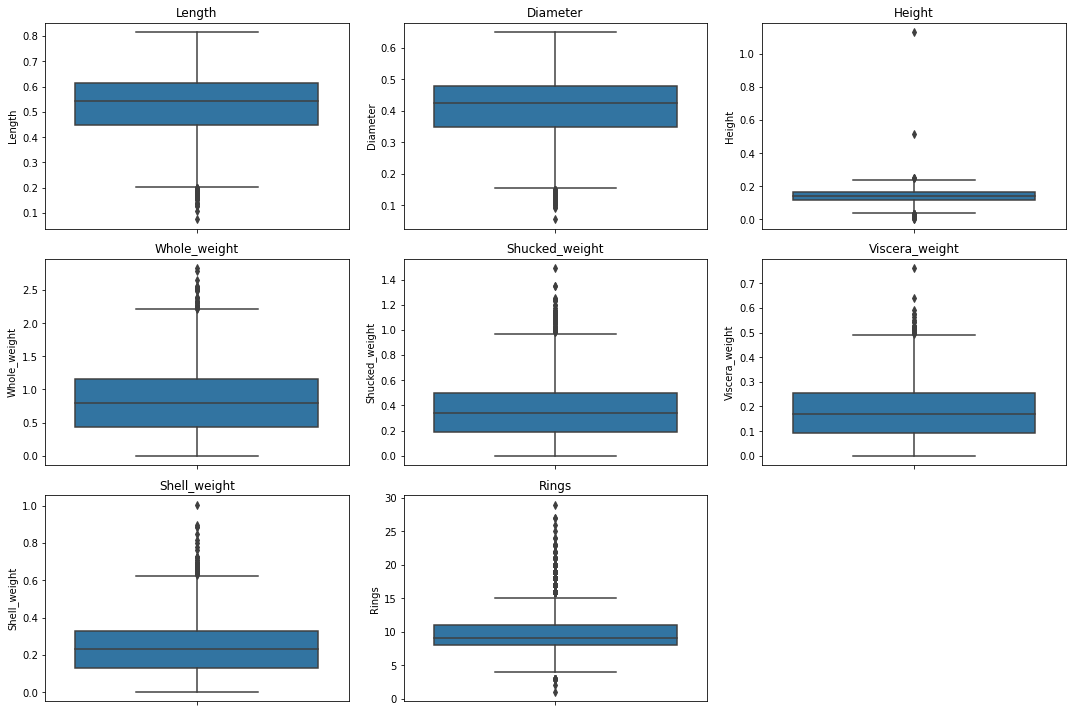

In [9]:
# Select only numerical columns
numerical_df = data_df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=['Ring Age'])

# Plot box plots for each numerical column
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_df.columns, 1):
    plt.subplot(3, 3, i)  # Adjust the subplot layout depending on the number of columns
    sns.boxplot(y=data_df[column])
    plt.title(column)

plt.tight_layout()
plt.show()


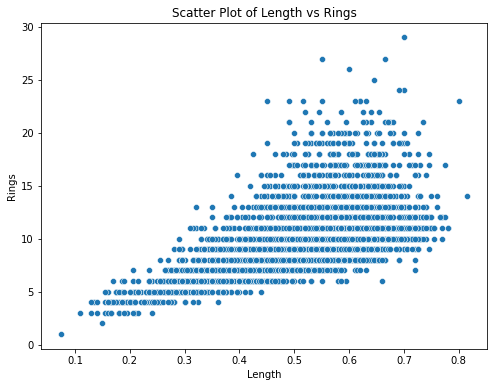

In [10]:
# Choose two variables to compare
variable1 = 'Length'
variable2 = 'Rings'

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_df[variable1], y=data_df[variable2])
plt.title(f"Scatter Plot of {variable1} vs {variable2}")
plt.xlabel(variable1)
plt.ylabel(variable2)
plt.show()


In [11]:
# Select only numerical columns
numerical_df = data_df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns=['Rings', 'Ring Age'])


# Initialize a dictionary to hold outlier percentages
outlier_percentages = {}

# Calculate IQR and detect outliers for each column
for column in numerical_df.columns:
    Q1 = numerical_df[column].quantile(0.25)
    Q3 = numerical_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers_count = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)].shape[0]
    total_count = numerical_df.shape[0]

    # Calculate and store the percentage of outliers
    outlier_percentages[column] = (outliers_count / total_count) * 100

# Sort the columns by the percentage of outliers
sorted_outlier_percentages = sorted(outlier_percentages.items(), key=lambda x: x[1], reverse=True)

# Get the top two columns with the most significant outliers
top_two_outlier_columns = [column for column, _ in sorted_outlier_percentages[:2]]


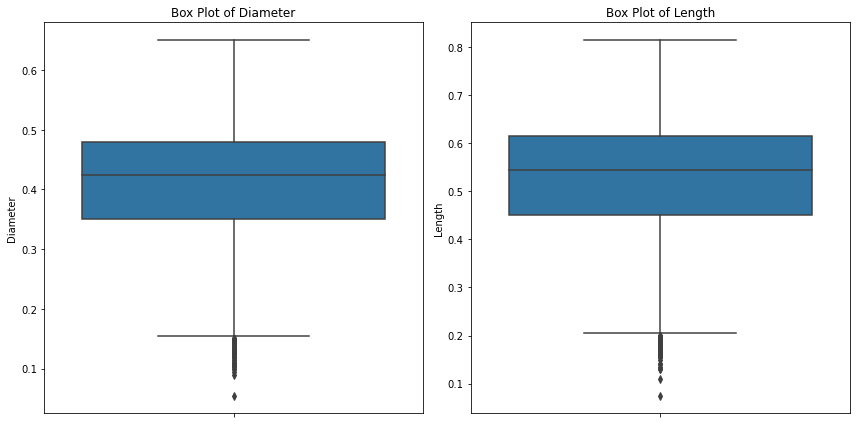

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot box plots for the two columns with the most significant outliers
plt.figure(figsize=(12, 6))

for i, column in enumerate(top_two_outlier_columns, 1):
    plt.subplot(1, 2, i)  # Layout for 2 plots
    sns.boxplot(y=data_df[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()


# Visualing Classes and Features

## Distribution of 'Ring Age' classes

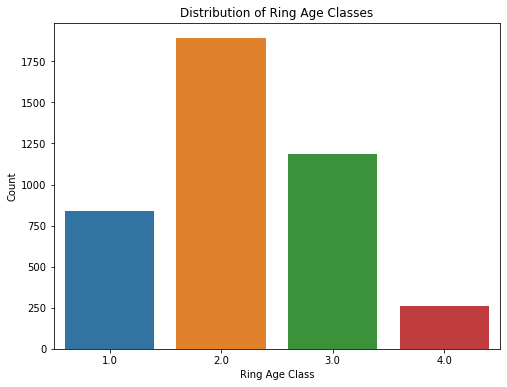

In [13]:
# 1. Distribution of 'Ring Age' classes
plt.figure(figsize=(8, 6))
sns.countplot(data=data_df, x='Ring Age')
plt.title('Distribution of Ring Age Classes')
plt.xlabel('Ring Age Class')
plt.ylabel('Count')
plt.show()

## Distribution of Features

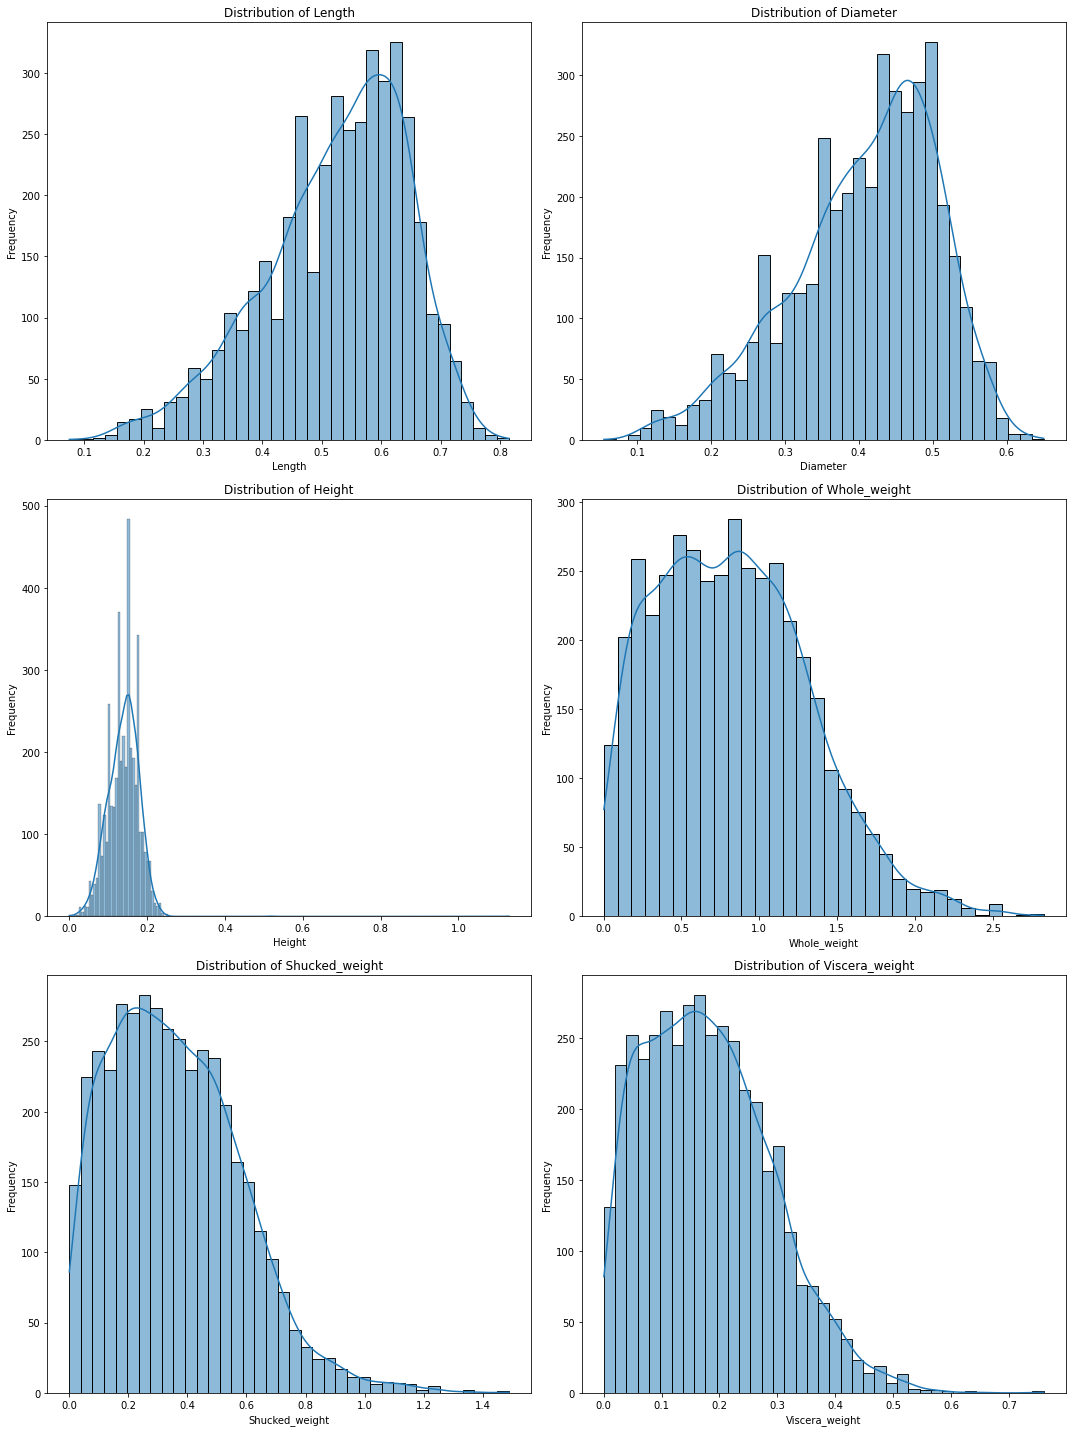

In [14]:
# Plotting Plot Distibutions in a 3x2 grid format

features = column_names[1:-2]  # Adjust according to your dataset

# Set up the matplotlib figure (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # Adjust the size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot each feature in its subplot
for i, feature in enumerate(features):
    if i < 6:  # Assuming we are only plotting the first 6 features
        sns.histplot(data=data_df, x=feature, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()


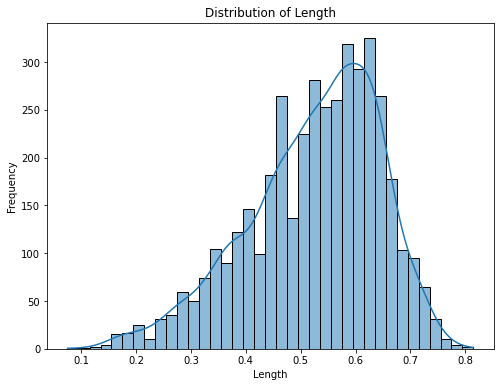

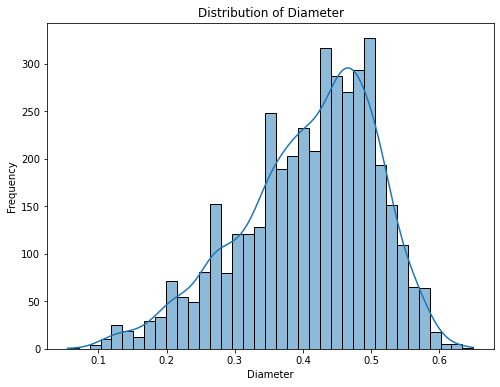

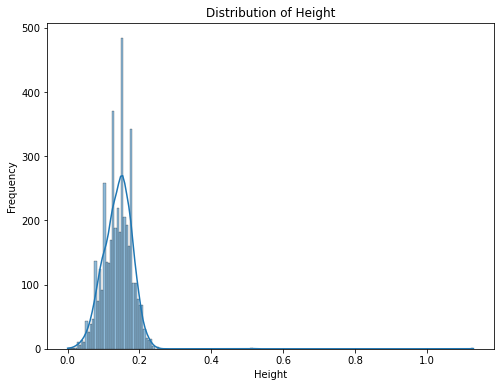

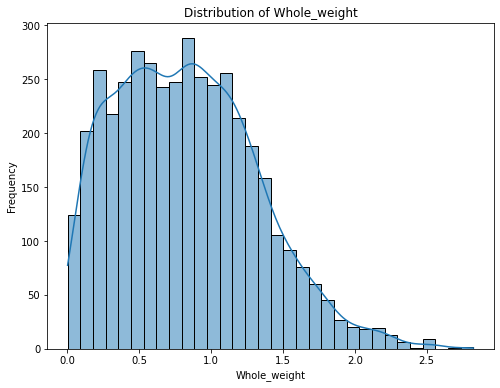

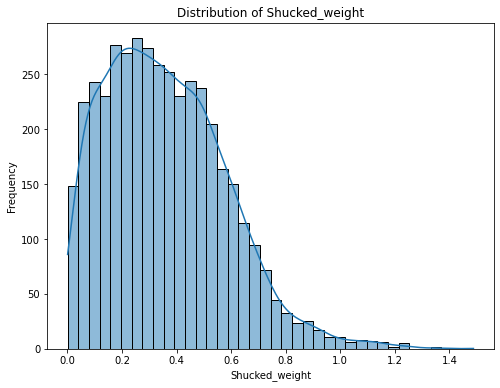

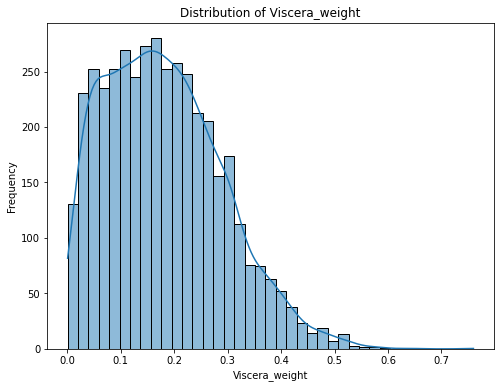

In [15]:
# Distribution of Features Individual Plots
features = column_names[1:-2]  
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=data_df, x=feature, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

## Boxplots for Features

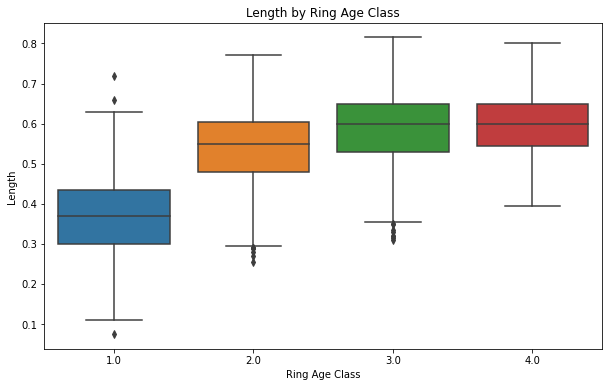

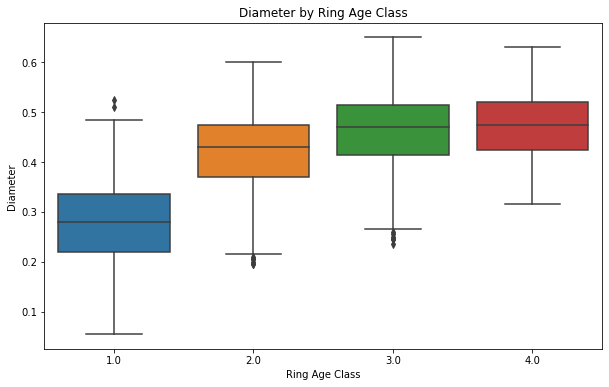

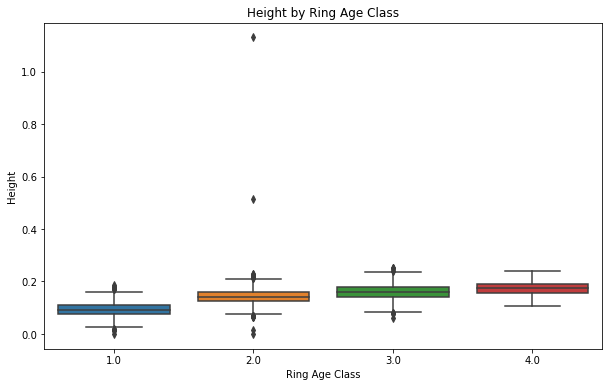

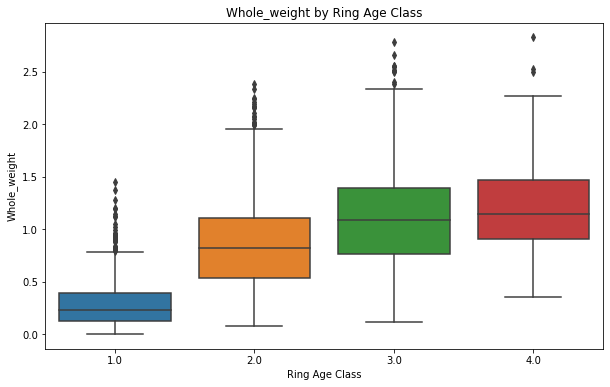

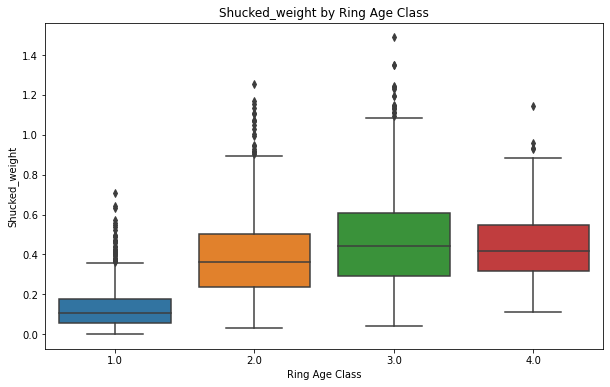

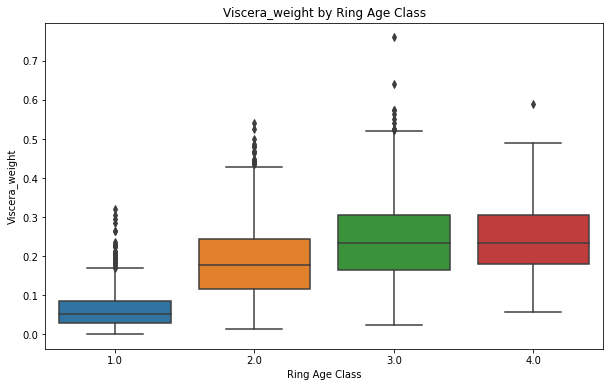

In [16]:
# Boxplot for features by 'Ring Age' class
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Ring Age', y=feature, data=data_df)
    plt.title(f'{feature} by Ring Age Class')
    plt.xlabel('Ring Age Class')
    plt.ylabel(feature)
    plt.show()

## Pairplot for a high-level overview of relationships

In [17]:

# Select a subset of features if the plot is too crowded)
#sns.pairplot(data_df, hue='Ring Age', vars=features)
#plt.show()


# Final Data Pre-procesing

In [18]:
# Encode the 'Sex' categorical variable
le = LabelEncoder()
data_df['Sex'] = le.fit_transform(data_df['Sex'])

In [19]:
data_df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Ring Age
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,3.0
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,1.0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,2.0
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,2.0
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,1.0


In [20]:
# Splitting the data into features and target
X = data_df.drop(['Rings','Ring Age'], axis=1)
y = data_df['Ring Age']

In [21]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Define Functions to Build and Run the Models

In [22]:
def build_and_run_models(hidden_layer_sizes, learning_rate_init, solver='sgd', random_state = None, max_iter=200):

    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                        learning_rate_init=learning_rate_init, 
                        solver=solver, 
                        activation = 'relu',
                        max_iter=max_iter, 
                        random_state=random_state)

    clf.fit(X_train, y_train)

    # Obtain the loss curve for the model
    loss_curve = clf.loss_curve_

    # Predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    # Accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    # Predict probabilities for use in ROC curve
    y_score = clf.predict_proba(X_test)

    return train_accuracy, test_accuracy, loss_curve, y_pred_train, y_pred_test, y_score

def run_experiments(hidden_neurons, learning_rates, solvers, num_runs=10):
    i = 0
    results = {}
    loss_curves = {}
    for neurons in hidden_neurons:
        for lr in learning_rates:
            for solver in solvers:
                experiment_name = f"Neurons: {neurons}, LR: {lr}, Solver: {solver}"
                accuracies = {'train': [], 'test': []}
                curves = []
                
                best_test_acc = 0 # to help keep track of which run is the best
                for run_num in range(1, num_runs+1):
                    if run_num == 1:
                        print(f"{i}: Running experiment: {experiment_name}")
                        i += 1
                    random_state = run_num*10 # Change the random seed for each run but make it reproducible
                    train_acc, test_acc, curve, y_pred_train, y_pred_test, y_score = build_and_run_models((neurons,), lr, solver, random_state = random_state)
                    print(f"     {random_state=}: {test_acc=}")
                    accuracies['train'].append(train_acc)
                    accuracies['test'].append(test_acc)
                    curves.append(curve)
                    # If the accuracy for this run is the best to date, record it
                    if test_acc > best_test_acc:
                        best_test_acc = test_acc
                        # Confusion Matrix for Training Data
                        best_cm = confusion_matrix(y_test, y_pred_test)
                        best_yscore = y_score
                        best_indiv_run_result = [best_test_acc, best_cm, best_yscore, y_pred_test, y_test]

                loss_curves[experiment_name] = curves
                mean_train = np.mean(accuracies['train'])
                mean_test = np.mean(accuracies['test'])
                std_test = np.std(accuracies['test'])
                conf_interval_train = stats.norm.interval(0.95, loc=mean_train, scale=stats.sem(accuracies['train']))
                conf_interval_test = stats.norm.interval(0.95, loc=mean_test, scale=stats.sem(accuracies['test']))
                results[experiment_name] = {'train': (mean_train, conf_interval_train), 'test': (mean_test, conf_interval_test), 
                                            'stdevn_test': std_test, 'best_indiv_run': best_indiv_run_result}
                
    return results, loss_curves


## Functions to Display Results

In [23]:
def display_results(results):
    
    for experiment, metrics in results.items():
        train_mean, train_conf_interval = metrics['train']
        test_mean, test_conf_interval = metrics['test']
        best_test_acc, best_cm, best_yscore, y_pred_test, y_test = metrics['best_indiv_run']

        print(f"Experiment Configuration: {experiment}")
        print(f"  Training Data: Mean Accuracy = {train_mean:.4f}, 95% Confidence Interval = {train_conf_interval}")
        print(f"  Test Data: Mean Accuracy = {test_mean:.4f}, 95% Confidence Interval = {test_conf_interval}")
        print(f"  Test Data: Standard Deviation = {metrics['stdevn_test']:.4f}")
        print(f"  Best Individual Run: Test Accuracy = {best_test_acc:.4f}")
        print()

def results_to_dataframe(results):

    data = []
    for experiment, metrics in results.items():
        # Splitting the experiment name to extract individual parameters
        params = experiment.split(", ")
        neurons = int(params[0].split(": ")[1])
        lr = float(params[1].split(": ")[1])
        solver = params[2].split(": ")[1]

        train_mean, train_conf_interval = metrics['train']
        test_mean, test_conf_interval = metrics['test']
        best_test_acc, best_cm, best_yscore, y_pred_test, y_test = metrics['best_indiv_run']
        
        row = {
            'Neurons': neurons,
            'Learning Rate': lr,
            'Solver': solver,
            'Train Mean Accuracy': train_mean,
            'Train 95% CI Lower': train_conf_interval[0],
            'Train 95% CI Upper': train_conf_interval[1],
            'Test Mean Accuracy': test_mean,
            'Test 95% CI Lower': test_conf_interval[0],
            'Test 95% CI Upper': test_conf_interval[1],
            'Test Standard Deviation': metrics['stdevn_test'],
        }
        data.append(row)

    return pd.DataFrame(data)

## Loss Curve Plot Functions

In [24]:
# Multiple Plots Per Row

def plot_loss_curves_multi(loss_curves):
    num_experiments = len(loss_curves)
    num_cols = 3
    num_rows = num_experiments // num_cols + (1 if num_experiments % num_cols > 0 else 0)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axs = axs.ravel()  # Flatten the array for easy iteration

    for i, (experiment, curves) in enumerate(loss_curves.items()):
        for curve in curves:
            axs[i].plot(curve, label='Run')
        axs[i].set_title(f'Loss Curve: {experiment}')
        axs[i].set_xlabel('Iterations')
        axs[i].set_ylabel('Loss')
        axs[i].legend()

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Indiv Plots 
def plot_loss_curves(loss_curves):
    for experiment, curves in loss_curves.items():
        plt.figure()
        for run, curve in enumerate(curves, start=1):
            plt.plot(curve, label=f'Run {run}')

        plt.title(f'Loss Curve: {experiment}')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()




In [25]:
# Suppress Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress only ConvergenceWarnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Suppress only specific RuntimeWarnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in multiply")

# Task 2 : Effect of Number of Neurons in The Hidden Layer

In [26]:
hidden_neurons = [5, 10, 15, 20]
learning_rates = [0.01]
solvers = ['sgd']


In [27]:
experiment_results, experiment_loss_curves = run_experiments(hidden_neurons, learning_rates, solvers)

0: Running experiment: Neurons: 5, LR: 0.01, Solver: sgd


     random_state=10: test_acc=0.639736684619988
     random_state=20: test_acc=0.6409335727109515
     random_state=30: test_acc=0.63016157989228
     random_state=40: test_acc=0.6343506882106523
     random_state=50: test_acc=0.6391382405745063
     random_state=60: test_acc=0.6379413524835428
     random_state=70: test_acc=0.6241771394374626
     random_state=80: test_acc=0.6343506882106523
     random_state=90: test_acc=0.6385397965290245
1: Running experiment: Neurons: 10, LR: 0.01, Solver: sgd
     random_state=10: test_acc=0.6427289048473968
     random_state=20: test_acc=0.6391382405745063
     random_state=30: test_acc=0.646918013165769
     random_state=40: test_acc=0.6463195691202872
     random_state=50: test_acc=0.6451226810293238
     random_state=60: test_acc=0.6535008976660682
     random_state=70: test_acc=0.639736684619988
     random_state=80: test_acc=0.6457211250748055
     random_state=90: test_acc=0.6415320167564332
2: Running experiment: Neurons: 15, LR: 0.01, S

In [28]:
# Assuming experiment_results contains the results from your experiments
display_results(experiment_results)

Experiment Configuration: Neurons: 5, LR: 0.01, Solver: sgd
  Training Data: Mean Accuracy = 0.6482, 95% Confidence Interval = (0.644692177079203, 0.6516632365946463)
  Test Data: Mean Accuracy = 0.6355, 95% Confidence Interval = (0.6319382440564855, 0.6390239209810836)
  Test Data: Standard Deviation = 0.0051
  Best Individual Run: Test Accuracy = 0.6409

Experiment Configuration: Neurons: 10, LR: 0.01, Solver: sgd
  Training Data: Mean Accuracy = 0.6533, 95% Confidence Interval = (0.6503518117895274, 0.6562013495122373)
  Test Data: Mean Accuracy = 0.6445, 95% Confidence Interval = (0.6416445170167612, 0.6474039569509228)
  Test Data: Standard Deviation = 0.0042
  Best Individual Run: Test Accuracy = 0.6535

Experiment Configuration: Neurons: 15, LR: 0.01, Solver: sgd
  Training Data: Mean Accuracy = 0.6569, 95% Confidence Interval = (0.6540660445671531, 0.6597585541736468)
  Test Data: Mean Accuracy = 0.6465, 95% Confidence Interval = (0.6421661577976971, 0.6507389555742025)
  Test 

In [29]:
# Run function to load results into a dataframe
experiment_results_df = results_to_dataframe(experiment_results)
experiment_results_df

,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper,Test Standard Deviation
0,5,0.01,sgd,0.648178,0.644692,0.651663,0.635481,0.631938,0.639024,0.005113
1,10,0.01,sgd,0.653277,0.650352,0.656201,0.644524,0.641645,0.647404,0.004156
2,15,0.01,sgd,0.656912,0.654066,0.659759,0.646453,0.642166,0.650739,0.006186
3,20,0.01,sgd,0.661789,0.660252,0.663327,0.644391,0.640512,0.648270,0.005598


In [30]:
optimal_num_neurons = experiment_results_df.loc[experiment_results_df['Test Mean Accuracy'].idxmax(), 'Neurons']
optimal_num_neurons

15

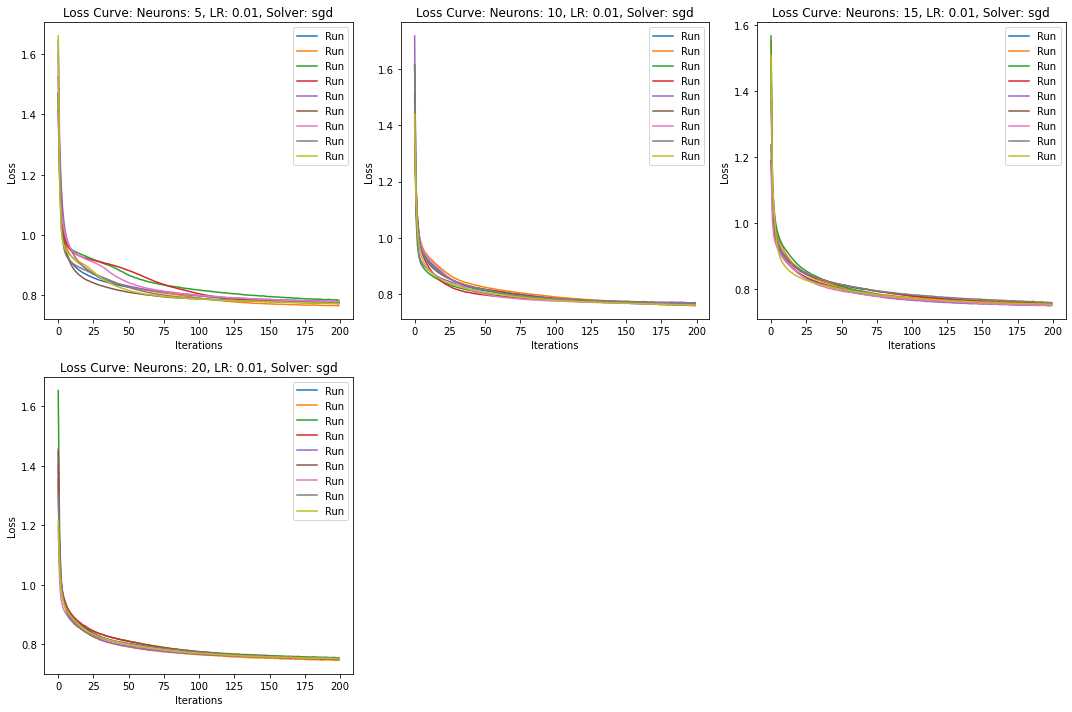

In [31]:
# Plot loss curves : Multiple Plots Per Row
plot_loss_curves_multi(experiment_loss_curves)

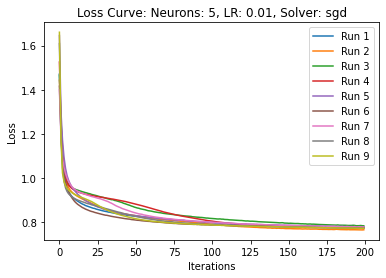

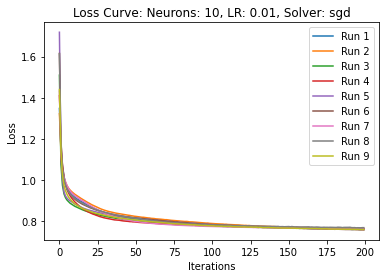

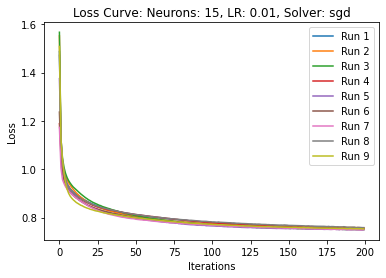

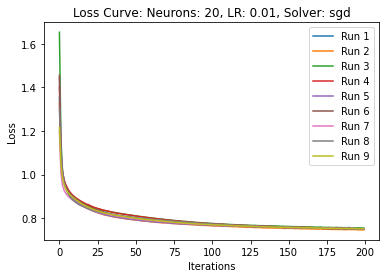

In [32]:
# Plot loss curves: Single Plot per row
plot_loss_curves(experiment_loss_curves)

# CHECKING 

## Data Checks

In [33]:
print(X.dtypes)
X.head()

Sex                 int32
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
dtype: object


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [34]:
y.unique()
y[:5]

0    3.0
1    1.0
2    2.0
3    2.0
4    1.0
Name: Ring Age, dtype: float64

In [35]:
X_train[:3]

array([[ 1.15198011, -0.86603404, -0.83526087, -0.58620751, -1.10179229,
        -1.16865694, -1.12766729, -0.9004559 ],
       [ 1.15198011,  0.25823017,  0.32368636,  0.25067161, -0.15039282,
        -0.23595721, -0.2563259 ,  0.15209245],
       [-0.0643548 , -0.36636106, -0.53292681, -0.70576167, -0.77344221,
        -0.71357157, -0.8356995 , -0.71006319]])

In [36]:
y_train[:3]

542     3.0
91      3.0
4158    2.0
Name: Ring Age, dtype: float64

## Model Checks

In [37]:
learning_rate_init = 0.01
solver = 'sgd'
max_iter = 200

In [38]:
"""

# 1 Hidden layer
nn1 = MLPClassifier(hidden_layer_sizes=(8,), random_state=2, max_iter=100, activation = activation, solver=solver,  
                alpha = alpha, learning_rate_init=0.01 )
        #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

# 2 Hidden layers
nn2 = MLPClassifier(hidden_layer_sizes=(8,4), random_state=2, max_iter=100,activation = activation, solver=solver,
                alpha = alpha, learning_rate='constant', learning_rate_init=0.01)
        #hidden_layer_sizes=(hidden,hidden, hidden) would implement 3 hidden layers

"""

"\n\n# 1 Hidden layer\nnn1 = MLPClassifier(hidden_layer_sizes=(8,), random_state=2, max_iter=100, activation = activation, solver=solver,  \n                alpha = alpha, learning_rate_init=0.01 )\n        #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html\n\n# 2 Hidden layers\nnn2 = MLPClassifier(hidden_layer_sizes=(8,4), random_state=2, max_iter=100,activation = activation, solver=solver,\n                alpha = alpha, learning_rate='constant', learning_rate_init=0.01)\n        #hidden_layer_sizes=(hidden,hidden, hidden) would implement 3 hidden layers\n\n"

In [46]:
num_neurons_list = [5,10,15,20]
num_runs = 10
exper_num = 1


for num_nuerons in num_neurons_list:
    for run_number in range(1, num_runs+1):

        random_state = 10 * run_number

        clf = MLPClassifier(hidden_layer_sizes=(num_nuerons,), 
                                learning_rate_init=learning_rate_init, 
                                solver=solver, 
                                activation = 'relu',
                                max_iter=max_iter, 
                                random_state=random_state
                                )
        if run_number == 1:
            print(f"Experiment Number: {exper_num}  Number of Neurons: {num_nuerons} ")
        
            
        clf.fit(X_train, y_train)

        # Obtain the loss curve for the model
        #loss_curve = clf.loss_curve_

        # Predictions
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)

        # Accuracy
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        # print train accuracy to 4 decimal places
        print(f"    Run Number: {run_number}, Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} random_state: {random_state}")
        

    # Update Experiment Number Counter
    print()
    exper_num += 1

Experiment Number: 1  Number of Neurons: 5 
    Run Number: 1, Train Accuracy: 0.6453 Test Accuracy: 0.6397 random_state: 10
    Run Number: 2, Train Accuracy: 0.6548 Test Accuracy: 0.6409 random_state: 20
    Run Number: 3, Train Accuracy: 0.6401 Test Accuracy: 0.6302 random_state: 30
    Run Number: 4, Train Accuracy: 0.6480 Test Accuracy: 0.6344 random_state: 40
    Run Number: 5, Train Accuracy: 0.6413 Test Accuracy: 0.6391 random_state: 50
    Run Number: 6, Train Accuracy: 0.6492 Test Accuracy: 0.6379 random_state: 60
    Run Number: 7, Train Accuracy: 0.6500 Test Accuracy: 0.6242 random_state: 70
    Run Number: 8, Train Accuracy: 0.6492 Test Accuracy: 0.6344 random_state: 80
    Run Number: 9, Train Accuracy: 0.6556 Test Accuracy: 0.6385 random_state: 90
    Run Number: 10, Train Accuracy: 0.6437 Test Accuracy: 0.6355 random_state: 100

Experiment Number: 2  Number of Neurons: 10 
    Run Number: 1, Train Accuracy: 0.6556 Test Accuracy: 0.6427 random_state: 10
    Run Number: 2

In [40]:
BREAK

NameError: name 'BREAK' is not defined

# Task 3: Efect of Learning Rate

In [ ]:
hidden_neurons = [5, 10, 15, 20]
learning_rates = [0.001, 0.01, 0.1]
solvers = ['adam', 'sgd']

experiment_results, experiment_loss_curves = run_experiments(hidden_neurons, learning_rates, solvers)


0: Running experiment: Neurons: 5, LR: 0.001, Solver: adam
1: Running experiment: Neurons: 5, LR: 0.001, Solver: sgd
2: Running experiment: Neurons: 5, LR: 0.01, Solver: adam
3: Running experiment: Neurons: 5, LR: 0.01, Solver: sgd
4: Running experiment: Neurons: 5, LR: 0.1, Solver: adam
5: Running experiment: Neurons: 5, LR: 0.1, Solver: sgd
6: Running experiment: Neurons: 10, LR: 0.001, Solver: adam
7: Running experiment: Neurons: 10, LR: 0.001, Solver: sgd
8: Running experiment: Neurons: 10, LR: 0.01, Solver: adam
9: Running experiment: Neurons: 10, LR: 0.01, Solver: sgd
10: Running experiment: Neurons: 10, LR: 0.1, Solver: adam
11: Running experiment: Neurons: 10, LR: 0.1, Solver: sgd
12: Running experiment: Neurons: 15, LR: 0.001, Solver: adam
13: Running experiment: Neurons: 15, LR: 0.001, Solver: sgd
14: Running experiment: Neurons: 15, LR: 0.01, Solver: adam
15: Running experiment: Neurons: 15, LR: 0.01, Solver: sgd
16: Running experiment: Neurons: 15, LR: 0.1, Solver: adam
17:

## Experiment_results

In [ ]:
# Assuming experiment_results contains the results from your experiments
display_results(experiment_results)


Experiment Configuration: Neurons: 5, LR: 0.001, Solver: adam
  Training Data: Mean Accuracy = 0.9758, 95% Confidence Interval = (0.9650006314873384, 0.9865556334767479)
  Test Data: Mean Accuracy = 0.9740, 95% Confidence Interval = (0.9616668352254943, 0.9862685328175932)

Experiment Configuration: Neurons: 5, LR: 0.001, Solver: sgd
  Training Data: Mean Accuracy = 0.8807, 95% Confidence Interval = (0.8440983083590262, 0.9172743971477576)
  Test Data: Mean Accuracy = 0.8867, 95% Confidence Interval = (0.850235367738609, 0.9231937166420014)

Experiment Configuration: Neurons: 5, LR: 0.01, Solver: adam
  Training Data: Mean Accuracy = 1.0000, 95% Confidence Interval = (nan, nan)
  Test Data: Mean Accuracy = 1.0000, 95% Confidence Interval = (nan, nan)

Experiment Configuration: Neurons: 5, LR: 0.01, Solver: sgd
  Training Data: Mean Accuracy = 0.9998, 95% Confidence Interval = (0.9994865510549235, 1.0001144066465932)
  Test Data: Mean Accuracy = 0.9997, 95% Confidence Interval = (0.9992

## DataFrame of Results

In [ ]:
# Run function to load results into a dataframe
experiment_results_df = results_to_dataframe(experiment_results)
experiment_results_df

,Neurons,Learning Rate,Solver,Train Mean Accuracy,Train 95% CI Lower,Train 95% CI Upper,Test Mean Accuracy,Test 95% CI Lower,Test 95% CI Upper
0,5,0.001,adam,0.975778,0.965001,0.986556,0.973968,0.961667,0.986269
1,5,0.001,sgd,0.880686,0.844098,0.917274,0.886715,0.850235,0.923194
2,5,0.010,adam,1.000000,NaN,NaN,1.000000,NaN,NaN
3,5,0.010,sgd,0.999800,0.999487,1.000114,0.999701,0.999230,1.000172
4,5,0.100,adam,0.998883,0.997628,1.000137,0.998803,0.997604,1.000002
5,5,0.100,sgd,1.000000,NaN,NaN,1.000000,NaN,NaN
6,10,0.001,adam,0.993456,0.991240,0.995672,0.993118,0.991153,0.995083
7,10,0.001,sgd,0.926696,0.916844,0.936548,0.928845,0.916665,0.941025
8,10,0.010,adam,1.000000,NaN,NaN,1.000000,NaN,NaN
9,10,0.010,sgd,0.999840,0.999713,0.999968,1.000000,NaN,NaN


## Loss Curve Plots

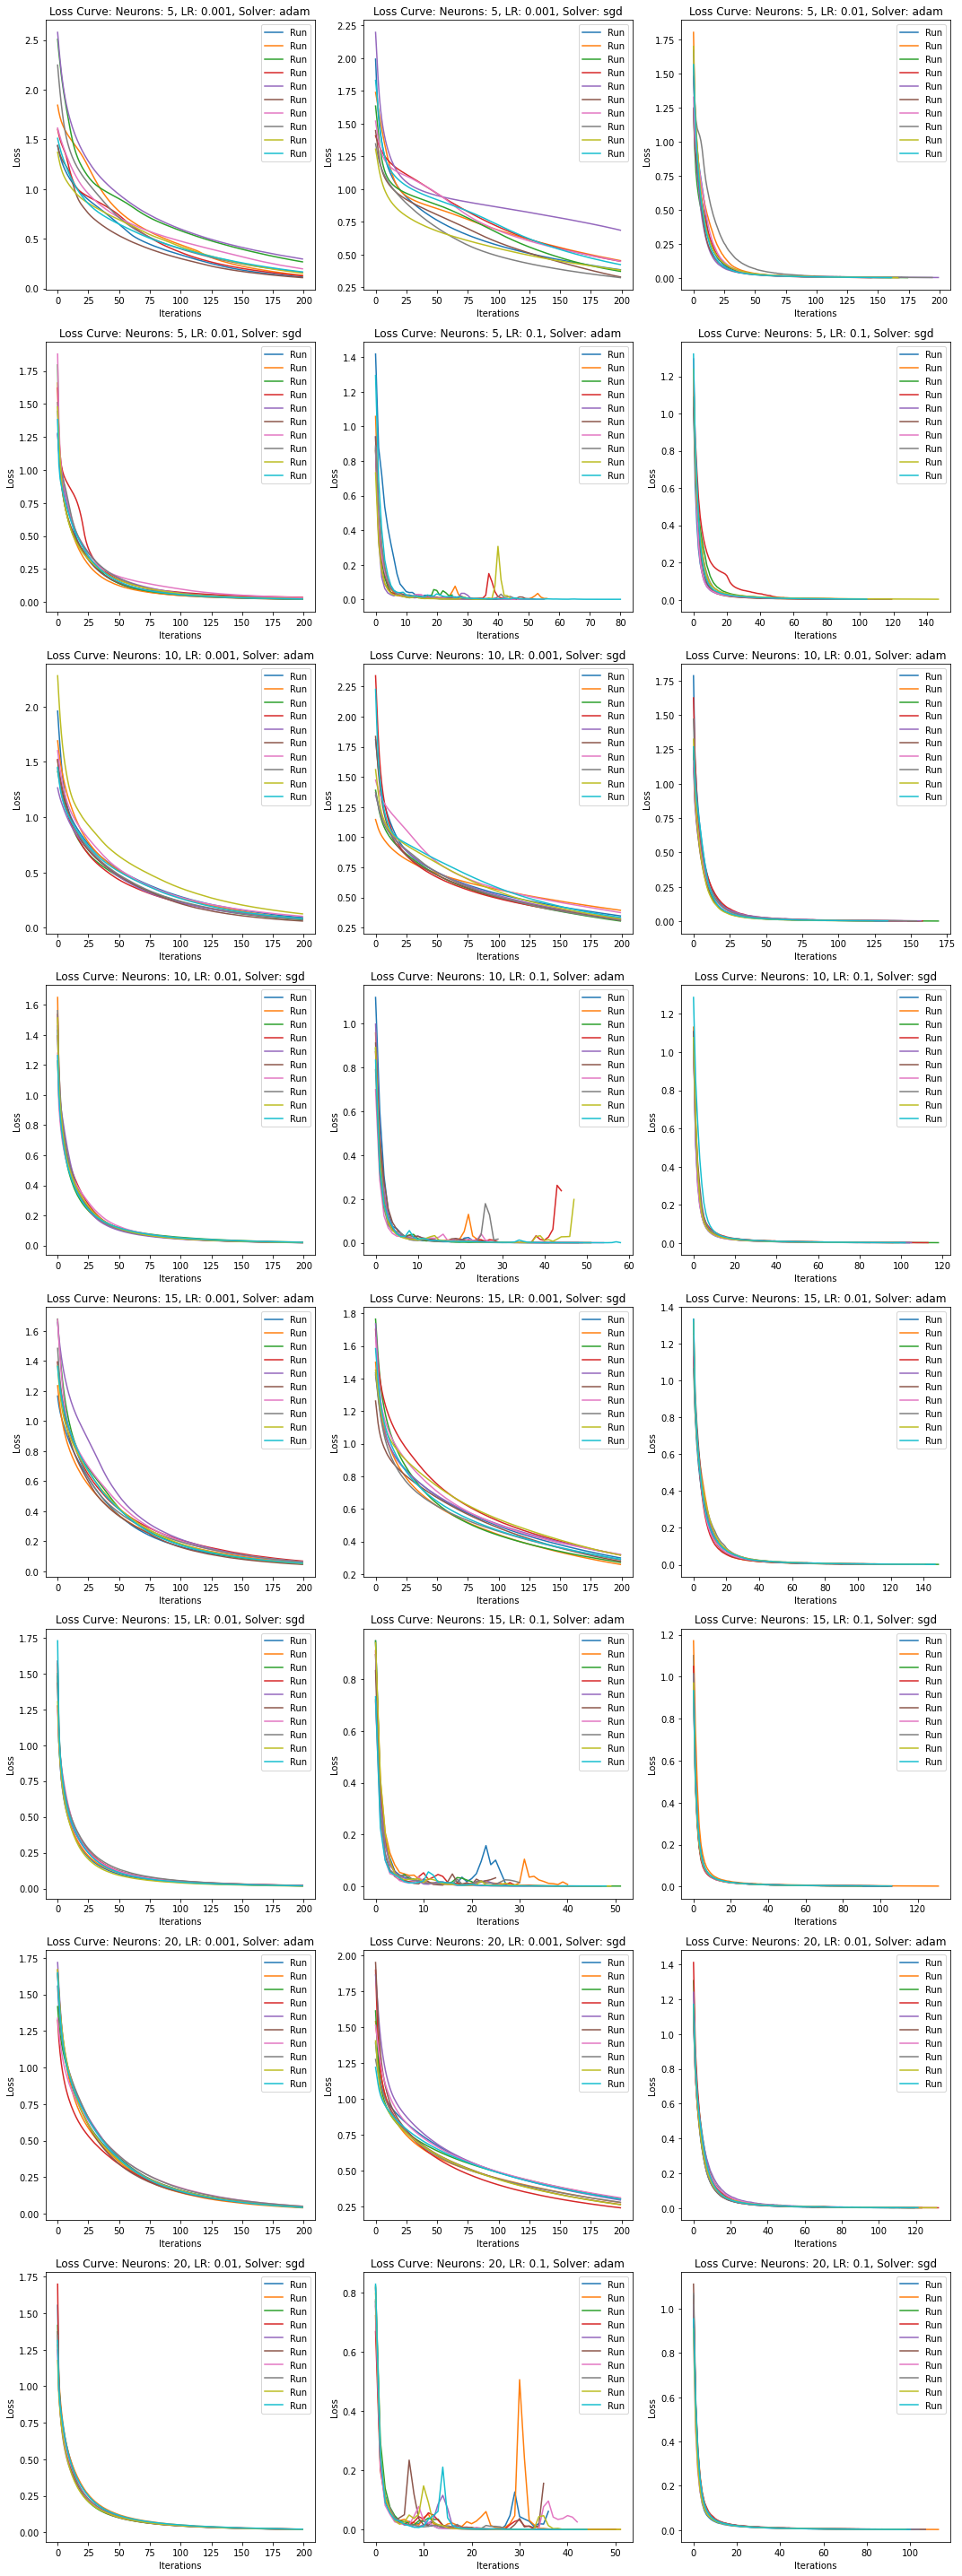

In [ ]:
# Multiple Plots Per Row


# Plot loss curves
plot_loss_curves_multi(experiment_loss_curves)


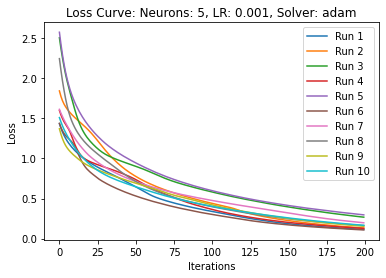

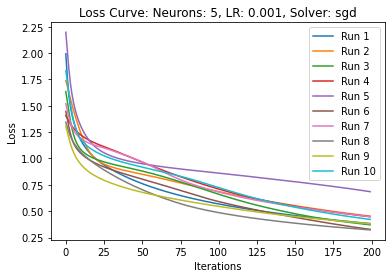

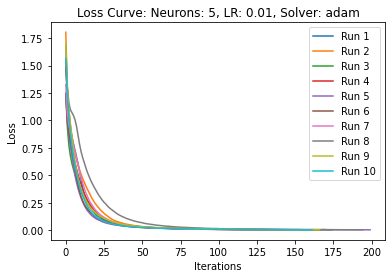

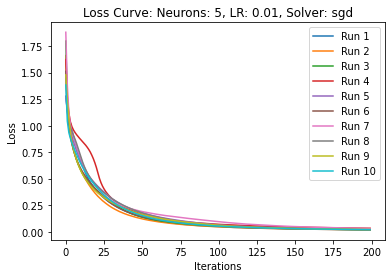

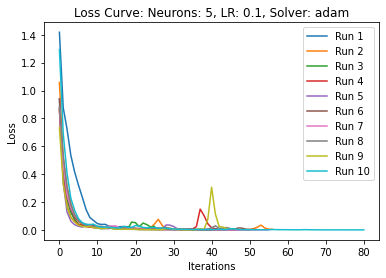

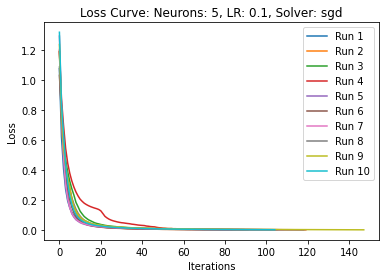

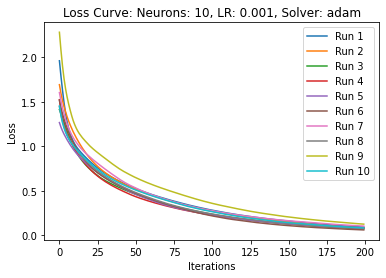

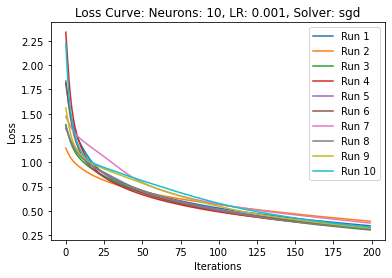

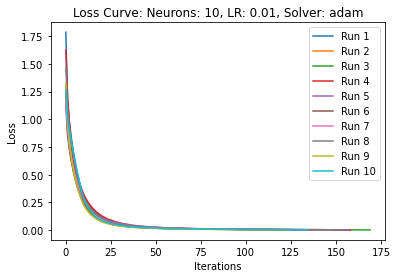

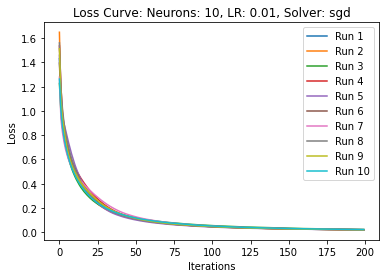

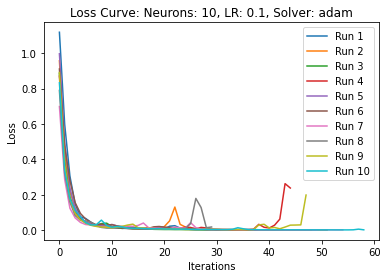

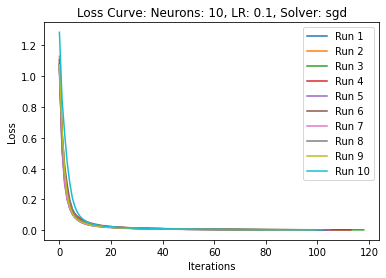

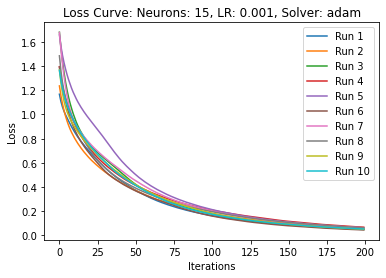

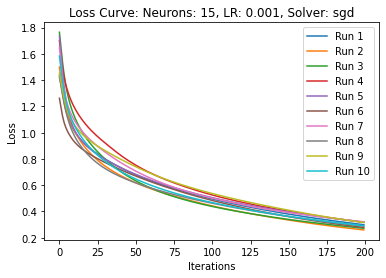

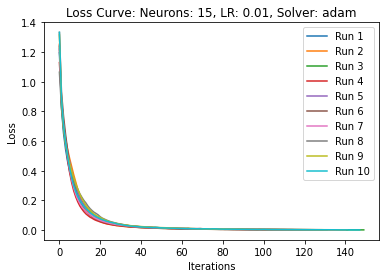

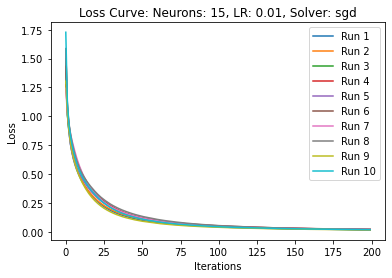

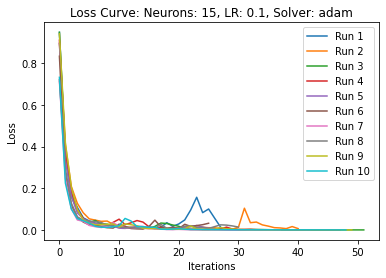

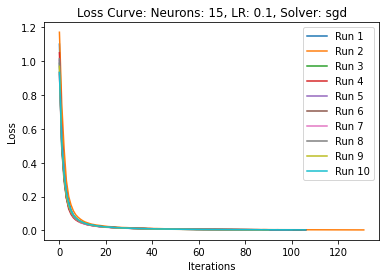

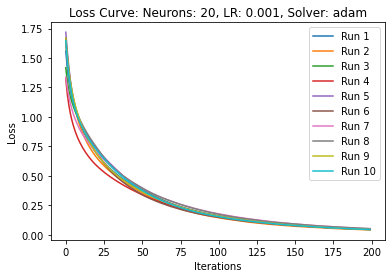

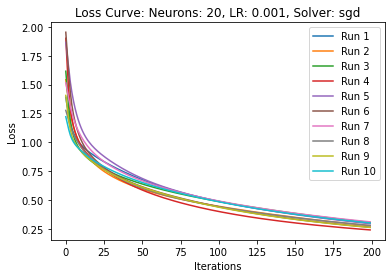

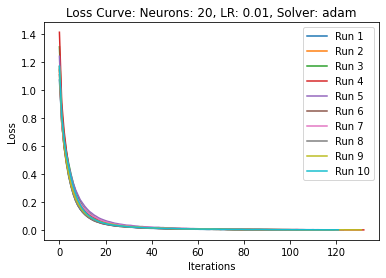

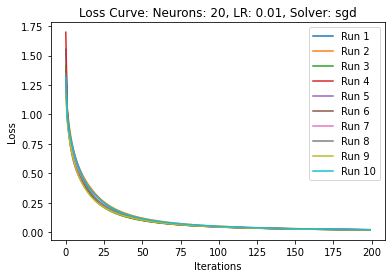

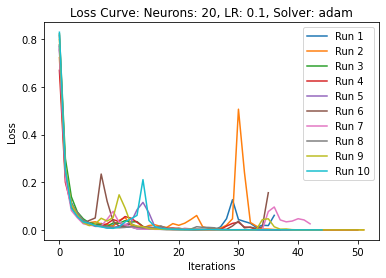

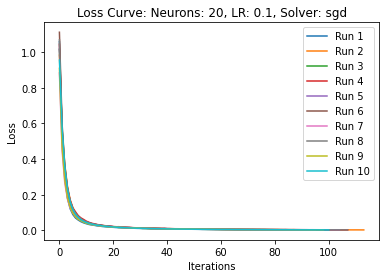

In [ ]:


# Plot loss curves
plot_loss_curves(experiment_loss_curves)


# END OF CODE

# working Notes

Standard Error of the Mean (SEM): SEM is a measure of how much discrepancy there is likely to be in our estimate of the mean accuracy. It is calculated as the standard deviation of the sample accuracies divided by the square root of the number of runs.

95% Confidence Interval: Using the mean accuracy and SEM, a 95% confidence interval is calculated. In the code, this is done using stats.norm.interval(0.95, loc=mean, scale=stats.sem(accuracies)). This function assumes a normal distribution and calculates the range within which the true mean accuracy is likely to lie with 95% confidence.

0.95 is the confidence level.
loc=mean is the mean accuracy calculated earlier.
scale=stats.sem(accuracies) is the standard error of the mean.
So, when we say "the 95% confidence interval has been achieved," it means that the calculated interval is the range in which we are 95% confident that the true mean accuracy lies, based on the sample data we have. This doesn't guarantee that the true mean is within this range, but it is very likely based on standard statistical assumptions.

The contents of the `experiment_results_df` DataFrame provide insightful information about the performance of various configurations of a neural network on your dataset. Here's an analysis based on the provided data:

1. **No Missing Values and Outliers:** The dataset has no missing values in any of the columns, which is good for model training. Also, there are a significant number of rows with outliers (396), which might affect the model's performance. Depending on the nature of these outliers, you might want to consider handling them (e.g., removing or transforming them) to improve model robustness.

2. **Experiment Configurations:** The experiments vary by the number of neurons in the hidden layer (5, 10, 15, 20), learning rate (0.001, 0.01, 0.1), and solver (adam, sgd). This range of parameters allows for a comprehensive understanding of how each factor influences model performance.

3. **High Accuracies with Certain Configurations:** Several configurations, especially those with a learning rate of 0.01 and 0.1, are achieving very high accuracies, close to 1.0 (100%). This could indicate a very well-fitting model, but it also raises concerns about potential overfitting, especially if these results are not consistent with the complexity of the problem or the quality of the dataset.

4. **Confidence Intervals:** In several cases, especially where accuracies are 1.0, the 95% confidence intervals are not computable (shown as NaN). This usually happens when the variance in the accuracy across runs is extremely low or zero, often a sign of overfitting. A model performing perfectly across multiple runs can indicate that it has memorized the training data, especially in cases where the test data is not sufficiently challenging or diverse.

5. **Solver Performance:** The 'adam' solver seems to generally perform better than 'sgd', particularly at lower learning rates. This is consistent with the general understanding that Adam optimization is more efficient and effective in many scenarios compared to traditional Stochastic Gradient Descent.

6. **Effect of Learning Rate and Neurons:** Higher learning rates (0.01 and 0.1) tend to give higher accuracies in this dataset, regardless of the number of neurons. However, this again should be cautiously interpreted in terms of potential overfitting.

7. **General Observations:** 
   - Lower learning rates (0.001) with the SGD solver tend to have lower performance.
   - Increasing the number of neurons does not always lead to better performance. For example, configurations with 5 neurons sometimes perform comparably or even better than those with more neurons.

### Recommendations:
- **Investigate Overfitting:** Given the high accuracies, investigate whether the model is overfitting. This can be done by checking the model's performance on a completely separate validation set, if available.
- **Analyze Data Complexity:** Ensure that the high accuracies align with the expected complexity of the data. If the data problem is not trivial, such high accuracies might be suspicious.
- **Outliers Handling:** Consider revisiting the outlier handling strategy, as they might affect the model's ability to generalize.
- **Experiment with More Configurations:** If computational resources allow, experimenting with more diverse configurations can provide further insights, especially in terms of neurons and hidden layers.